# Minecraft Text Planning Task

In [1]:
import os

# from plancraft.llms import get_llm_generator, LLMGeneratorBase
from plancraft.models.react import TransformersGenerator
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

# model_name = "meta-llama/Llama-2-7b-chat-hf"
model_name = "microsoft/Phi-3-mini-128k-instruct"
# llm = get_llm_generator(
#     model_name=model_name,
#     outlines=False,
#     # quantize="int4",
# )

# llm = TransformersGenerator(model_name=model_name)

# model = TransformersGenerator(
#     model_name,  # quantize="quantize"
# )
tokenizer = AutoTokenizer.from_pretrained(
    model_name,# token=os.getenv("HF_TOKEN"), trust_remote_code=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    # config=BitsAndBytesConfig(),
)

# chat_template = open("plancraft/models/templates/phi-instruct.jinja").read()
# chat_template = chat_template.replace("    ", "").replace("\n", "")
# tokenizer.chat_template = chat_template
# TransformersGenerator.fix_tokenizer_system_prompt(model_name, tokenizer)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     device_map="auto",
#     **model_kwargs,
# )
# model.eval()
# if tokenizer.pad_token_id is None:
#     tokenizer.pad_token = tokenizer.eos_token
#     model.config.pad_token_id = model.config.eos_token_id
# tokenizer.truncation_side = "left"
# tokenizer
# 


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:43<00:00, 21.66s/it]


In [65]:
import transformers
import torch


def truncate_kv_cache(past_ids: torch.Tensor, new_ids: torch.Tensor, kv_cache: tuple[tuple[torch.Tensor]])->tuple[tuple[torch.Tensor]]:
    """
    Truncate the key-value cache to the size which overlap the past_ids with the new_ids.

    past_ids: torch.Tensor [B, T]
    new_ids: torch.Tensor [B, T]
    kv_cache: tuple[tuple[torch.Tensor]]: tuple of key-value cache tensors
    """
    min_shape = min(past_ids.shape[-1],new_ids.shape[-1])

    # Find the first token that is different between the past and new tokens
    seq_min = torch.argmax((past_ids[:,:min_shape] != new_ids[:,:min_shape]).double(), dim=1).min()

    # Truncate the key-value cache to the size which overlap the past_ids with the new_ids.
    # assumes shape is [num_layers, num_heads, seq_len, hidden_size]
    return [[kv[:, :, :seq_min, :] for kv in kvs] for kvs in kv_cache]


kv_cache = {}

model_name = "meta-llama/Llama-2-7b-chat-hf"

texts = ["10+10 = ", 
        "what you up to mate? I'm"]
input_tokens = tokenizer(texts, 
                          truncation=True, 
                          return_tensors="pt", 
                          padding=True)
print(texts[0])

input_tokens = {k: v.to(model.device) for k, v in input_tokens.items()}
forward_outputs = model.generate(
    input_ids=input_tokens["input_ids"],
    attention_mask=input_tokens["attention_mask"],
    max_new_tokens=64,
    return_dict_in_generate=True,
    do_sample=True,
    temperature=1.0
)

kv_cache["past_key_values"] = forward_outputs.past_key_values
past_tokens = forward_outputs.sequences


print(forward_outputs.sequences.shape)
intermediate_output = tokenizer.batch_decode(forward_outputs.sequences, skip_special_tokens=True)
print(intermediate_output[0])

# intermediate_output[0] += "... The correct answer is "

intermediate_output[0] = "1+2 = "
intermediate_output[1] += "... but anyways what's up w/ u? "

print(intermediate_output[0])
input_tokens = tokenizer(intermediate_output, truncation=True, padding=True, return_tensors="pt")
input_tokens = {k: v.to(model.device) for k, v in input_tokens.items()}

kv_cache["past_key_values"] = truncate_kv_cache(past_tokens, input_tokens["input_ids"], kv_cache["past_key_values"])
print(input_tokens["input_ids"].shape)
print(kv_cache["past_key_values"][0][0].shape)

# forward_outputs = model.generate(
#     input_ids=input_tokens["input_ids"],
#     attention_mask=input_tokens["attention_mask"],
#     max_new_tokens=64,
#     return_dict_in_generate=True,
#     do_sample=True,
#     temperature=1.0,
#     **kv_cache
# )
# # 
# print(forward_outputs.sequences.shape)
# output = tokenizer.batch_decode(forward_outputs.sequences, skip_special_tokens=True)
# print(output[0])

# # for text in t.batch_decode(new_gen, skip_special_tokens=False):
# #     print("\n" + "#" * 80 + "\n\n" + text)
# forward_outputs.past_key_values[0][0].shape

10+10 = 
torch.Size([2, 74])
10+10 = 20 > 0 < 8+8 =16 .

Une seconde stratégie d'attaque consiste à écrire une expression rationnelle avec d'abord le plus grand diviseur commun des dénominateurs (à l'origine, les nombres
1+2 = 
torch.Size([2, 87])
torch.Size([2, 32, 0, 96])


In [57]:
past_ids = past_tokens
new_ids = input_tokens["input_ids"]
kv_cache_tensor = kv_cache["past_key_values"]
# past_tokens.shape, input_tokens["input_ids"].shape

B, T_past = past_ids.shape
_, T_new = new_ids.shape

min_shape = min(T_past,T_new)

print(past_ids[:,:min_shape])
print(new_ids[:,:min_shape])
print((past_ids[:,:min_shape] == new_ids[:,:min_shape]).double())

# Find the first token that is different between the past and new tokens
seq_min = torch.argmax((past_ids[:,:min_shape] != new_ids[:,:min_shape]).double(), dim=1).min()

# Truncate the key-value cache to the size which overlap the past_ids with the new_ids.
# assumes shape is [num_layers, num_heads, seq_len, hidden_size]
new_cache = [[kv[:, :, :seq_min, :] for kv in kvs] for kvs in kv_cache_tensor]




tensor([[32000,     1, 29871, 29896, 29900, 29974, 29896, 29900,   353, 29871,
         29906, 29900, 32007, 32000, 32000, 32000, 32000],
        [    1,   825,   366,   701,   304, 15358, 29973,   306, 29915, 29885,
           925,   263,  4943,  1410, 29891, 29889, 32007]], device='cuda:0')
tensor([[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000],
        [    1,   825,   366,   701,   304, 15358, 29973,   306, 29915, 29885,
           925,   263,  4943,  1410, 29891,  3045,   541]], device='cuda:0')
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]],
       device='cuda:0', dtype=torch.float64)


torch.Size([2, 32, 1, 96])

In [40]:
new_ids

tensor([[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000,     1, 29871, 29896, 29974, 29906,   353, 29871],
        [    1,   825,   366,   701,   304, 15358, 29973,   306, 29915, 29885,
           925,   263,  4943,  1410, 29891,  3045,   541,   738,  1994,   825,
         29915, 29879,   701,   281, 29914,   318, 29973, 29871]],
       device='cuda:0')

In [100]:
output[0]

"This is an ad about: A) 5-Hour Energy B) Adderall C) Caffeine D) None of the above... The correct answer is  ... but anyways what's up w/ u?   _Ethene) was \\(3\\) \\)"

In [3]:
# llm.generate("Hello, how are you?", max_length=100, num_return_sequences=1)

In [2]:
# model = model.cuda()

In [5]:
batch_messages = [
    [
        {
            "content": "list 3 flag emojis",
            "role": "user",
        },
    ],
    [
        {
            "content": "list 3 happy emojis",
            "role": "user",
        },
    ],
    [
        {
            "content": "list 3 purple devil emojis",
            "role": "user",
        },
    ],
]

In [6]:
# llm.generate_thoughts(batch_messages)



You are not running the flash-attention implementation, expect numerical differences.


(['think:🚩, 🏳️, 🗳️',
  'think:😊, 😁, 😃',
  'think:😈💜 (black devil with a purple heart),  \n\n🔵👹🌌 (interpreted as a blue or purple devil in space, depending on emoji platform-specific tint),  \n\n👹💜 (devil with a purple heart, assuming emoji variations include color).'],
 102)

In [5]:
model.generate_actions(batch_messages)

([SymbolicMoveAction(action_type='move', slot_from=12, slot_to=11, quantity=20),
  SymbolicMoveAction(action_type='move', slot_from=13, slot_to=7, quantity=10),
  SymbolicMoveAction(action_type='move', slot_from=8, slot_to=15, quantity=50)],
 ['act: smelt from slot 12 to slot 11 with quantity 20',
  'act: smelt from slot 13 to slot 7 with quantity 10',
  'act: smelt from slot 8 to slot 15 with quantity 50'],
 33)

In [167]:
from plancraft.models.utils import tokenize, Trie
new_message_start = "act: "
tokenized_messages = tokenize(
    model, tokenizer, batch_messages, new_message_start=new_message_start
)
prompt_tokens = tokenized_messages["input_ids"].shape[1]

In [200]:
import torch


class ValidActionsLogitsProcessor(torch.nn.Module):
    def __init__(self, choices: list[str], tokenizer: AutoTokenizer):
        super().__init__()
        self.choices = choices
        self.tree = Trie()
        self.start_idx = None

        encoded_choices = tokenizer(choices, add_special_tokens=False)["input_ids"]
        for choice in encoded_choices:
            self.tree.insert(choice + [tokenizer.eos_token_id])

    def forward(self, input_ids, scores):
        if self.start_idx is None:
            # Calculate start_idx during the first forward pass
            self.start_idx = input_ids.shape[-1]

        decoded_so_far = input_ids[:, self.start_idx :]
        mask = torch.full_like(scores, float("-inf"))
        for batch_idx in range(input_ids.shape[0]):
            valid_next_tokens = self.tree.get_next(decoded_so_far[batch_idx].tolist())
            if len(valid_next_tokens) == 0:
                valid_next_tokens = [tokenizer.eos_token_id]
            mask[batch_idx, valid_next_tokens] = 0
        return scores + mask

    def reset(self):
        self.start_idx = None


choices = ["🥰", "🇯🇵", "😄", "🥰", "😈", "🇯🇵", "😄"]
valid_actions = ValidActionsLogitsProcessor(choices, tokenizer)

# tokenizer.batch_decode(tokenized_messages["input_ids"], skip_special_tokens=True)

In [169]:
tokenized_messages = {k: v.cuda() for k, v in tokenized_messages.items()}

In [170]:
tokenizer.decode([29901])

':'

In [205]:
prompt_tokens = tokenized_messages["input_ids"].shape[1]

generated_sequence = model.generate(
    input_ids=tokenized_messages["input_ids"],
    attention_mask=tokenized_messages["attention_mask"],
    do_sample=True,
    temperature=0.1,
    max_new_tokens=valid_actions.tree.longest_sequence_length,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    logits_processor=[valid_actions],
)


tokenizer.batch_decode(generated_sequence["sequences"][:, prompt_tokens:], skip_special_tokens=True)

['🇯🇵', '😄', '😈']

In [36]:
tokenize(
    model,
    tokenizer,
    batch_messages,
    new_message_start=f"{new_message_start}jaaa",
)["input_ids"].shape

torch.Size([3, 16])

In [29]:

# Generate the initial action constrained to valid action tokens
generated_sequences = model.generate(
    **tokenized_messages,
    do_sample=True,
    temperature=temperature,
    max_new_tokens=valid_actions.tree.longest_sequence_length,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    logits_processor=[valid_actions],
)

    # Select only new tokens
    generated_choices = []
    for seq in generated_sequences.sequences:
        generated_choice = seq[prompt_tokens:]
        # Decode the generated choice
        generated_choice_text = tokenizer.decode(
            generated_choice, skip_special_tokens=True
        )
        generated_choices.append((generated_choice_text, seq.shape[-1]))

    # return generated_choices


# model.generate_thought(batch_messages, max_tokens=24, temperature=1)

Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.76s/it]


In [33]:
from plancraft.models.utils import tokenize, Trie
from transformers import AutoModelForCausalLM, AutoTokenizer

def decode_with_choices(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    messages: list[dict],
    choices: list[str],
    new_message_start: str = "act:",
    temperature=1.0,
) -> tuple[str, int]:
    """
    Uses the Trie data structure to constrain the generation over a set of choices
    Returns the generated choice and the full generated sequence
    """
    tokenized_messages, prompt_tokens = tokenize(
        model, tokenizer, messages, new_message_start=new_message_start
    )

    class ValidActionsLogitsProcessor(torch.nn.Module):
        def __init__(self, choices: list[str]):
            super().__init__()
            self.choices = choices
            self.tree = Trie()
            self.step = 0
            self.start_idx = len(tokenized_messages[0])

            for choice in choices:
                tokenized_messages_with_choice, _ = tokenize(
                    model,
                    tokenizer,
                    messages,
                    new_message_start=f"{new_message_start}{choice}",
                )
                # find tokens that are different from the original message
                idxs = tokenized_messages_with_choice[0][self.start_idx :].tolist() + [
                    tokenizer.eos_token_id
                ]
                # insert the token idxs into the trie
                self.tree.insert(idxs)

        def forward(self, input_ids, scores):
            decoded_so_far = input_ids[0][self.start_idx :]
            valid_next_tokens = self.tree.get_next(decoded_so_far.tolist())
            mask = torch.full_like(scores, float("-inf"))
            mask[:, valid_next_tokens] = 0
            scores = scores + mask
            # print(scores[:, valid_next_tokens])
            return scores

    valid_actions = ValidActionsLogitsProcessor(choices)

    # Generate the initial action constrained to valid action tokens
    generated_sequence = model.generate(
        tokenized_messages,
        do_sample=True,
        temperature=temperature,
        max_new_tokens=valid_actions.tree.longest_sequence_length,
        pad_token_id=tokenizer.pad_token_id,
        return_dict_in_generate=True,
        use_cache=True,
        logits_processor=[valid_actions],
    )

    # select only new tokens
    generated_choice = generated_sequence[0][0][prompt_tokens:]
    # decode the generated choice
    generated_choice = tokenizer.decode(generated_choice, skip_special_tokens=True)

    return generated_choice, generated_sequence.sequences.shape[-1]

In [144]:
import torch


def tokenize(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    batch_messages: list[list[dict]],
    max_tokens=256,
    new_message_start="act:",
) -> dict[str, torch.Tensor]:
    """
    Tokenize a list of messages and start the response message
    """
    message_text = tokenizer.apply_chat_template(
        batch_messages,
        add_generation_prompt=True,
        tokenize=False,
    )
    # add the start of the response message
    message_text = [m + new_message_start for m in message_text]

    max_prompt_length = None
    # need to truncate if max_length is set
    if model.generation_config.max_length > max_tokens:
        max_prompt_length = model.generation_config.max_length - max_tokens

    tokenized_messages = tokenizer(
        message_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_prompt_length,
        padding=True,
    )
    return tokenized_messages


messages = [
    [
        {
            "content": "YOU ARE A very nice please answer only with friendly emojis",
            "role": "system",
        },
    ],
    [
        {
            "content": "YOU ARE A bad bOT and answer in emojis",
            "role": "system",
        },
    ],
    [
        {
            "content": "YOU ARE A weird bOT and answer in irrelevant emojis",
            "role": "system",
        },
    ],
]

# out = tokenize(model, tokenizer, messages)
# out = tokenizer.apply_chat_template(
#     messages, tokenize=True, return_tensors="pt", return_dict=True, padding=True
# )
# out = tokenizer.apply_chat_template(
#     messages, tokenize=False, add_generation_prompt=True
# )
# out = [o + "act:" for o in out]
# print(len(out))
# print(out)
# max_prompt_length = None
# max_tokens = 256
# # need to truncate if max_length is set
# if model.generation_config.max_length > max_tokens:
#     max_prompt_length = model.generation_config.max_length - max_tokens

# tokenized_messages = tokenizer(
#     out,
#     return_tensors="pt",
#     truncation=True,
#     max_length=max_prompt_length,
#     padding=True,
# )
# print(tokenized_messages)

tokenized_messages = tokenize(model, tokenizer, messages)
tokenized_messages = {k: v.to("cuda") for k, v in tokenized_messages.items()}
# print(out["input_ids"].shape)
tokenizer.batch_decode(tokenized_messages["input_ids"])

['<s><|system|> YOU ARE A very nice please answer only with friendly emojis<|end|> act:',
 '<|endoftext|><s><|system|> YOU ARE A bad bOT and answer in emojis<|end|> act:',
 '<s><|system|> YOU ARE A weird bOT and answer in irrelevant emojis<|end|> act:']

In [147]:
pred = model.generate(
    input_ids=tokenized_messages["input_ids"],
    attention_mask=tokenized_messages["attention_mask"],
    max_new_tokens=32,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    output_scores=True,
    return_dict_in_generate=True,
    do_sample=True,
    temperature=1,
)

In [148]:
tokenizer.batch_decode(pred["sequences"], skip_special_tokens=True)

['YOU ARE A very nice please answer only with friendly emojis act: Provide a detailed explanation of the Pythagorean theorem and its applications in real-world scenarios. �������',
 'YOU ARE A bad bOT and answer in emojis act: Tell me the capital of France. 🇫🇷🏙️🗼 ��',
 "YOU ARE A weird bOT and answer in irrelevant emojis act: How does one efficiently solve a Rubik's Cube?\n\n ���������������"]

In [ ]:
overall_message = "act:"
action = decode_with_choices(
    model,
    tokenizer,
    messages,
    choices=["move", "smelt"],  # ["move", "sme lt"] -> [1] [2, 3] -> [1, 2] -> [eos, 3] -> [eos]
    new_message_start=overall_message,
)
overall_message += f"{action} from slot "
print(overall_message)
from_slot = decode_with_choices(
    model,
    tokenizer,
    messages,
    choices=[str(i) for i in range(47)],
    new_message_start=overall_message,
)
overall_message += f"{from_slot} to slot "
print(overall_message)
to_slot = decode_with_choices(
    model,
    tokenizer,
    messages,
    choices=[str(i) for i in range(47)],
    new_message_start=overall_message,
)
overall_message += f"{to_slot} with quantity "
quantity = decode_with_choices(
    model,
    tokenizer,
    messages,
    choices=[str(i) for i in range(64)],
    new_message_start=overall_message,
)
overall_message += f"{quantity}"
print(overall_message)

In [2]:
from plancraft.environments.actions import SymbolicMoveAction, SymbolicSmeltAction
# from pydantic import model_dump

print(SymbolicMoveAction(slot_from=1, slot_to=2, quantity=1).model_dump())
print(SymbolicSmeltAction(slot_from=1, slot_to=2, quantity=1).model_dump())

{'action_type': 'move', 'slot_from': 1, 'slot_to': 2, 'quantity': 1}
{'action_type': 'smelt', 'slot_from': 1, 'slot_to': 2, 'quantity': 1}


In [397]:
import torch
# from plancraft.utils import Trie

def decode_with_choices(
    model,
    tokenizer,
    choices: list[str],
    messages: list[dict],
    new_message_start: str = "act:",
):
    tokenized_messages, prompt_tokens = tokenize(
        messages, 256, new_message_start=new_message_start
    )

    class ValidActionsLogitsProcessor(torch.nn.Module):
        def __init__(self, choices: list[str]):
            super().__init__()
            self.choices = choices
            self.tree = Trie()
            self.step = 0
            self.start_idx = len(tokenized_messages[0])

            for choice in choices:
                tokenized_messages_with_choice, _ = tokenize(
                    messages,
                    256,
                    new_message_start=f"{new_message_start}{choice}",
                )
                # find tokens that are different from the original message
                idxs = tokenized_messages_with_choice[0][self.start_idx :].tolist() + [
                    tokenizer.eos_token_id
                ]
                self.tree.insert(idxs)

        def forward(self, input_ids, scores):
            print(
                "input_ids",
                self.start_idx,
                len(input_ids[0]),
                tokenizer.decode(input_ids[0]),
            )
            decoded_so_far = input_ids[0][self.start_idx :]
            valid_next_tokens = self.tree.get_next(decoded_so_far.tolist())
            print(
                "valid_next_tokens",
                valid_next_tokens,
                [tokenizer.decode(v) for v in valid_next_tokens],
            )
            mask = torch.full_like(scores, float("-inf"))
            mask[:, valid_next_tokens] = 0
            scores = scores + mask
            print(scores[:, valid_next_tokens])
            return scores

    valid_actions = ValidActionsLogitsProcessor(choices)
    # Generate the initial action constrained to valid action tokens
    generated_choice = model.generate(
        tokenized_messages,
        do_sample=True,
        temperature=1.0,
        max_new_tokens=valid_actions.tree.longest_sequence_length,
        pad_token_id=tokenizer.pad_token_id,
        return_dict_in_generate=True,
        use_cache=True,
        logits_processor=[valid_actions],
    )

    # select only new tokens
    generated_choice = generated_choice[0][0][prompt_tokens:]
    # decode the generated choice
    generated_choice = tokenizer.decode(generated_choice, skip_special_tokens=True)
    return generated_choice


decode_with_choices(
    model,
    tokenizer,
    choices=["move", "hoolo"],
    messages=messages,
    new_message_start="act:",
)

input_ids 19 19 <s><|system|> You are a minecraft bot<|end|><|user|> What action to take?<|end|><|assistant|> act:
valid_next_tokens [11631, 1251] ['move', 'ho']
tensor([[8.1875, 6.9062]], device='cuda:0')
input_ids 19 20 <s><|system|> You are a minecraft bot<|end|><|user|> What action to take?<|end|><|assistant|> act:move
valid_next_tokens [32000] ['<|endoftext|>']
tensor([[5.4375]], device='cuda:0')


'move'

In [100]:
# tokenizer.decode(initial_action_output.sequences[0])

import torch

a = torch.arange(0, 5).unsqueeze(0)
b = torch.arange(0, 10).unsqueeze(0)

# Find the minimum length to compare
min_length = min(a.size(1), b.size(1))

# Compare elements up to the minimum length
comparison = (a[:, :min_length] != b[:, :min_length]).squeeze().int()

# Find the index of the first differing element
first_diff_index = torch.argmax(comparison).item()

# Check if there is a differing element within the compared range
if comparison[first_diff_index]:
    print(f"The first differing element is at index {first_diff_index}.")
else:
    print("No differing element found within the compared range.")


# move_token_id
# tokenizer.encode(" smelt", add_special_tokens=False)
# smelt_token_id

0
No differing element found within the compared range.


LlamaTokenizerFast(name_or_path='/nfs/public/hf/models/microsoft/Phi-3-mini-128k-instruct', vocab_size=32000, model_max_length=131072, is_fast=True, padding_side='left', truncation_side='left', special_tokens={'bos_token': '<s>', 'eos_token': '<|endoftext|>', 'unk_token': '<unk>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|/inst|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=False),
	32000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|assistant|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=True),
	32002: AddedToken("<|step|>", rstrip=True

In [43]:
messages = [
    {
        "content": "Answer all queries in poetic french in under 10 words.",
        "role": "system",
    },
    {"content": "Whats the meaning of life?", "role": "user"},
]

message_text = llm.tokenizer.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
print(message_text)

<s>[INST] <<SYS>>
Answer all queries in poetic french in under 10 words.
<</SYS>>

Whats the meaning of life? [/INST]


In [44]:
# thought_generator(message_text, max_tokens=64)
out = llm.model.generate(
    llm.tokenizer.tokenizer.encode(message_text + "{\"thought\":\"", return_tensors="pt").cuda(),
    temperature=1.0,
    max_length=64)
text_out = llm.tokenizer.tokenizer.decode(out[0], skip_special_tokens=True)
print(text_out)

[INST] <<SYS>>
Answer all queries in poetic french in under 10 words.
<</SYS>>

Whats the meaning of life? [/INST]{"thought":"La vie, c'est une aventure,"}


In [45]:
llm.model.generation_config

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_length": 4096,
  "pad_token_id": 0,
  "temperature": 0.6,
  "top_p": 0.9
}

In [46]:
# thought_generator(message_text, max_tokens=64)

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [43,0,0], thread: [1,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [48,0,0], thread: [72,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [1,0,0], thread: [39,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [46,0,0], thread: [107,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [29,0,0], thread: [67,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [6,0,0], thread: [36,0,0] Assertion `-sizes[

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [39]:
def constrained_choice(llm, tokenizer, prompt: str, choices: list):
    """
    Given a prompt and a list of choices, generate text and apply constraints to sample the best option.
    """
    # Generate text
    text = llm.generate_text(prompt, max_length=128, do_sample=True, temperature=0.7)
    print(text)
    # Calculate the score for each choice
    scores = []
    for choice in choices:
        score = llm.get_score(text + choice)
        scores.append(score)
    # Choose the best option
    best_choice = choices[scores.index(max(scores))]
    return best_choice
    


In [2]:
# LLMGeneratorBase.build_model_kwargs(model_name="meta-llama/Meta-Llama-3-8B-Instruct")

messages = [
    {
        "content": "Answer all queries in poetic french in under 10 words.",
        "role": "system",
    },
    {"content": "Whats the meaning of life?", "role": "user"},
]

text = llm.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
text += "act:"
print(text)

encoded = llm.tokenizer.encode(text,return_tensors="pt")
encoded = encoded.to(llm.model.device)
# llm.thought_generator(text, max_tokens=50)

<|system|>
Answer all queries in poetic french in under 10 words.<|end|>
<|user|>
Whats the meaning of life?<|end|>
<|assistant|>
act:


In [3]:
encoded.shape

torch.Size([1, 30])

In [4]:
smelt_idx = llm.tokenizer.encode(" smelt", add_special_tokens=False)[0]
move_idx = llm.tokenizer.encode(" move", add_special_tokens=False)[0]
move_idx, smelt_idx

(29871, 29871)

In [5]:
import torch
with torch.no_grad():
    out = llm.model._orig_mod(encoded, return_dict=True)

You are not running the flash-attention implementation, expect numerical differences.


In [6]:
probs = out["logits"][0, -1, [smelt_idx, move_idx]].softmax(dim=-1)
dist = torch.distributions.categorical.Categorical(probs=probs).sample()
dist

if dist == 0:
    print("smelt")
    # add smelt to text
    text += " smelt"
    new_encoded = llm.tokenizer.encode(text,return_tensors="pt")
    # add only new tokens to encoded
    new_encoded = new_encoded.to(llm.model.device)
    new_out = llm.model._orig_mod(new_encoded, return_dict=True)
    
else:
    print("move")

smelt


In [279]:



trie = Trie()
trie.insert([1, 2, 3, 4])
trie.insert([1, 2, 3, 4, 5])
trie.insert([1, 2, 4, 5])
trie.insert([1, 2, 1000, 5, 6])
trie.insert([0, 1, 2, 4, 5])
trie.get_next([])

[1, 0]

In [2]:

thought_message, thinking_token_used = llm.generate(
    messages=messages,
    max_tokens=32,
    mode="think"
)

You are not running the flash-attention implementation, expect numerical differences.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:1135: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:1143: PydanticDeprecatedSince20: `load_str_bytes` is deprecated. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  obj = parse.load_str_bytes(
/

In [26]:
thought_message

'"Être, vivre, aimer, mourir, peut-être trouver sens."'

In [6]:
messages = [
    {"role": "system", "content": "I need to obtain wooden_slab."},
    {"role": "user", "content": "I need to obtain wooden_slab."},
    {"role": "assistant", "content": "How to obtain wooden_slab?"},
    {"role": "user", "content": "I need to obtain wooden_slab."},
]


message_text = (
    tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False,
    )
    + '{"'
)

encoded_input = tokenizer.encode(
    message_text,
    return_tensors="pt",
)

encoded_input

tensor([[    1,     1,   518, 25580, 29962,  3532, 14816, 29903,  6778,    13,
         29902,   817,   304,  4017, 27278, 29918,  2536,   370, 29889,    13,
         29966,   829, 14816, 29903,  6778,    13,    13, 29902,   817,   304,
          4017, 27278, 29918,  2536,   370, 29889,   518, 29914, 25580, 29962,
          1128,   304,  4017, 27278, 29918,  2536,   370, 29973, 29871,     2,
             1,   518, 25580, 29962,   306,   817,   304,  4017, 27278, 29918,
          2536,   370, 29889,   518, 29914, 25580,  3199, 29908]])

In [34]:
from transformers import StoppingCriteria, StoppingCriteriaList

stopping_criteria = StoppingCriteriaList(
    [
        StoppingCriteria(max_length=100),
        StoppingCriteria(max_tokens=100),
        StoppingCriteria(no_repeat_ngram_size=3),
        StoppingCriteria()
    ]
)


encoded = tokenizer.encode(
    '"}',
    return_tensors="pt",
    add_special_tokens=False,
)

encoded

tensor([[12990]])

In [2]:
import wandb
import dotenv
import os

# dotenv.load_dotenv()

# api = wandb.run(api_key=os.environ["WANDB_API_KEY"])

run = wandb.init(
    # api_key=os.environ["WANDB_API_KEY"],
    project="plancraft",
    entity="itl",
    group="one_shot",
    job_type="generation",
    config={"model": "gpt-4-turbo-preview"},
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: gautierdag (itl). Use `wandb login --relogin` to force relogin


In [4]:
# create a Table with the same columns as above,
# plus confidence scores for all labels
columns = ["id", "image", "guess", "truth"]
# for digit in range(10):
    # columns.append("score_" + str(digit))
test_table = wandb.Table(columns=columns)

# run inference on every image, assuming my_model returns the
# predicted label, and the ground truth labels are available
for i in range(10):
    true_label = i
    guess_label = i
    test_table.add_data(i, str(i+i), i*0.5, i*0.5)

In [5]:
# my_table = wandb.Table(columns=["a", "b"], data=[["1a", "1b"], ["2a", "2b"]])
run.log({"table_key": test_table})

In [6]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [2]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

now = time.time()
model_id = "CohereForAI/c4ai-command-r-v01"
# model_id = "CohereForAI/c4ai-command-r-v01-4bit"
# model_id = "google/gemma-2b-it"
print("loading tokenizer")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# print("loading model")
# model = AutoModelForCausalLM.from_pretrained(
#     model_id, trust_remote_code=True, device_map="auto", torch_dtype=torch.float16
# )
# time_taken = time.time() - now
# print(f"loading time taken: {time_taken:.2f}s")

# # Format message with the command-r chat template
# print("Getting chat")
messages = [
    {"role": "system", "content": "You are a human helper"},
    {"role": "user", "content": "Hello, how are you?"},
]
input_ids = tokenizer.apply_chat_template(
    messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
)
tokenizer.decode(input_ids[0])
# ## <BOS_TOKEN><|START_OF_TURN_TOKEN|><|USER_TOKEN|>Hello, how are you?<|END_OF_TURN_TOKEN|><|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>

# print("Sending to cuda")
# # use cuda
# input_ids = input_ids.to("cuda")
# # model = model.to("cuda")

# print("Generating")
# with torch.no_grad():
#     gen_tokens = model.generate(
#         input_ids,
#         max_new_tokens=100,
#         do_sample=True,
#         temperature=0.3,
#     )

#     gen_text = tokenizer.decode(gen_tokens[0])
#     print(gen_text)

# time_taken = time.time() - now
# print(f"Total time taken: {time_taken:.2f}s")

loading tokenizer


tokenizer_config.json: 100%|██████████| 7.92k/7.92k [00:00<00:00, 9.82MB/s]
tokenizer.json: 100%|██████████| 12.8M/12.8M [00:00<00:00, 58.4MB/s]
special_tokens_map.json: 100%|██████████| 439/439 [00:00<00:00, 4.98MB/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.

No chat template is defined for this tokenizer - using the default template for the CohereTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



'<BOS_TOKEN><|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|>You are a human helper<|END_OF_TURN_TOKEN|><|START_OF_TURN_TOKEN|><|USER_TOKEN|>Hello, how are you?<|END_OF_TURN_TOKEN|><|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>'

In [4]:
results = []
done = [False] * 4

done[1] = True

results.append(
    {
        "success": done[1],
    }
)

done[1]=False

print(results)

[{'success': True}]


/tmp/ipykernel_24784/3763962699.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/plancraft/demo_env_0.png")


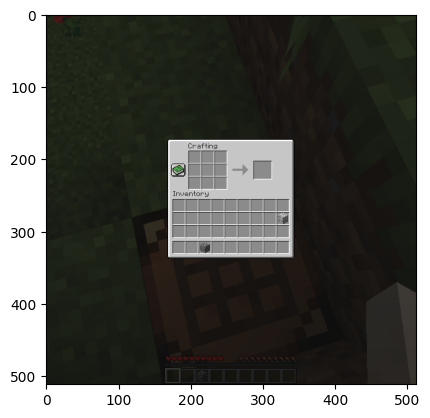

In [6]:
import imageio
from matplotlib import pyplot as plt

# read image at index 0

image = imageio.imread("/plancraft/demo_env_0.png")

# print the shape of the image
plt.imshow(image)

(164, 171, 3)


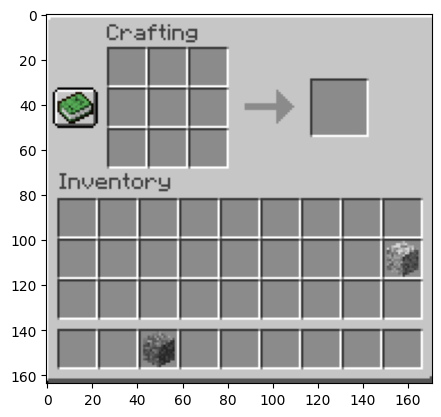

In [29]:
# crop at position x=174, y=170 with width=164 and height=173
cropped_image = image[174 : 174 + 164, 170 : 168 + 173]
print(cropped_image.shape)
plt.imshow(cropped_image)

In [7]:
import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

DEVICE = "cuda"

tokenizer = AutoProcessor.from_pretrained(
    "/nfs/public/hf/models/HuggingFaceM4/idefics2-8b-chatty"
)
model = AutoModelForVision2Seq.from_pretrained(
    "/nfs/public/hf/models/HuggingFaceM4/idefics2-8b-chatty",
    # "HuggingFaceM4/idefics2-8b",
).to(DEVICE)

# processor.tokenizer.pad_token_id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards: 100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


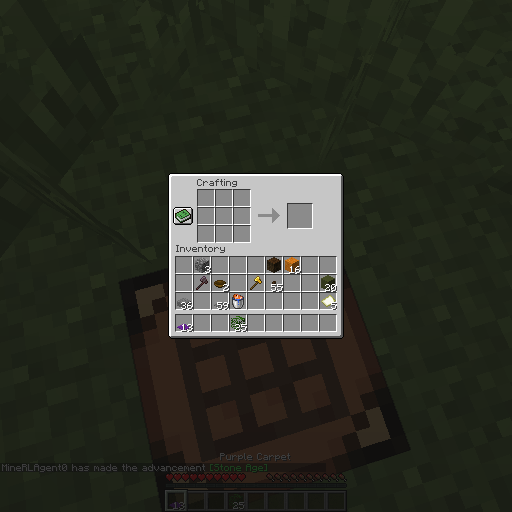

In [104]:
from plancraft.models.utils import tokenize
from PIL import Image

path = "/plancraft/local.png"
image = Image.open(path)
image.show()

In [125]:
# Create inputs
batch_messages = [
    [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": "Be a helpful bot and describe this image",
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What's the image below:",
                },
                {"type": "image"},
            ],
        },
    ]
]


import base64
import glob
import io
import pathlib

import numpy as np
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer


def tokenize(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    batch_messages: list[list[dict]],
    start_messages_generation: list[str],
    max_tokens=256,
    images=None,
) -> dict[str, torch.Tensor]:
    """
    Tokenize a list of messages and start the response message
    """
    assert len(start_messages_generation) == len(
        batch_messages
    ), "Length of start_messages_generation should be equal to batch_messages"

    message_texts = tokenizer.apply_chat_template(
        batch_messages,
        add_generation_prompt=True,
        tokenize=False,
    )
    print(message_texts)
    # add the start of the response message for each message
    # message_texts = [
    #     messages_text + new_message_start
    #     for (messages_text, new_message_start) in zip(
    #         message_texts, start_messages_generation
    #     )
    # ]

    max_prompt_length = None
    # need to truncate if max_length is set
    if model.generation_config.max_length > max_tokens:
        max_prompt_length = model.generation_config.max_length - max_tokens

    tokenized_messages = tokenizer(
        text=message_texts,
        images=images,
        return_tensors="pt",
        # truncation=True,
        # max_length=1000,
        # padding=True,
    )
    return tokenized_messages


# prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
tokenized_messages = tokenize(
    model,
    tokenizer,
    batch_messages,
    start_messages_generation=[""] * len(batch_messages),
    max_tokens=256,
    # images=[[image]],
)

["System: Be a helpful bot and describe this image<end_of_utterance>\nUser: What's the image below:<image><end_of_utterance>\nAssistant:"]


In [126]:
print(tokenizer.batch_decode(tokenized_messages["input_ids"])[0])

<s> System: Be a helpful bot and describe this image<end_of_utterance> 
User: What's the image below:<fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><i

In [122]:
prompt_tokens = tokenized_messages["input_ids"].shape[-1]
tokenized_messages = {k: v.to(model.device) for k, v in tokenized_messages.items()}

In [123]:
generated_sequences = model.generate(
    input_ids=tokenized_messages["input_ids"],
    attention_mask=tokenized_messages["attention_mask"],
    do_sample=True,
    temperature=1.0,
    max_new_tokens=256,
    pad_token_id=tokenizer.tokenizer.pad_token_id,
    return_dict_in_generate=True,
    # use_cache=True,
)

In [124]:
text_responses = tokenizer.batch_decode(
    generated_sequences.sequences,
    skip_special_tokens=True,
)
print(text_responses)

["System: Be a helpful bot and describe this image \nUser: What's the image below: \nAssistant:"]


In [134]:
from transformers.image_utils import load_image

image1 = load_image(
    "https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg"
)
image2 = load_image(
    "https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg"
)
image3 = load_image(
    "https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg"
)


# Create inputs
messages = [
    # {
    #     "role": "user",
    #     "content": [
    #         {"type": "image"},
    #         {"type": "text", "text": "What do we see in this image?"},
    #     ],
    # },
    # {
    #     "role": "assistant",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty.",
    #         },
    #     ],
    # },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "And how about this image?"},
        ],
    },
]
prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(text=prompt, images=[image], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}


# Generate
generated_ids = model.generate(
    **inputs,
    # input_ids=inputs["input_ids"],
    # attention_mask=inputs["attention_mask"],
    do_sample=True,
    temperature=1.0,
    max_new_tokens=100,
    # pad_token_id=tokenizer.tokenizer.pad_token_id,
)
generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts)

['User: And how about this image? \nAssistant: The image presents a Crafting Inventory in a game. The interface is a grid composed of 9 pixels in the shape of a 3x3 square. Each field in the grid is currently filled with a green and black checkerboard pattern. On the right side of the grid, there\'s a small toolbar with two buttons. The top button, labeled "Crafting", has been highlighted, indicating its active status. The bottom button is labeled "Inventory", suggesting its']


In [135]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'pixel_attention_mask'])